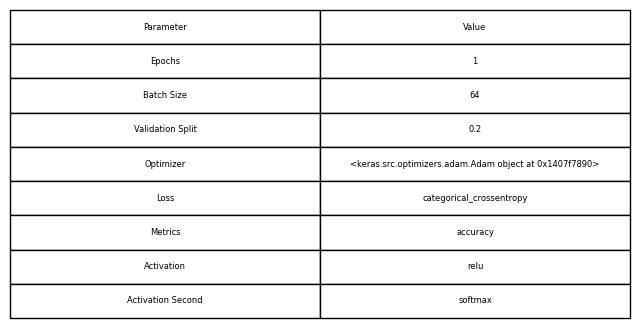

ValueError: The `strides` argument must be a tuple of 2 integers. Received: relu

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras.utils import plot_model
from graphviz import Digraph


############################ Parameters  ####################################################
epochs = 1  # Increase the number of epochs
batch_size = 64
validation_split = 0.2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'
metrics = 'accuracy'
activationFirst = 'relu'
activationSecond = 'softmax'
#############################################################################################

# Display parameters in a table
param_table_data = [
    ("Epochs", epochs),
    ("Batch Size", batch_size),
    ("Validation Split", validation_split),
    ("Optimizer", optimizer),
    ("Loss", loss),
    ("Metrics", metrics),
    ("Activation", activationFirst),
    ("Activation Second", activationSecond),
]

param_table_headers = ["Parameter", "Value"]

plt.figure(figsize=(8, 4))
plt.table(cellText=param_table_data, colLabels=param_table_headers, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
plt.axis('off')
plt.show()

# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation=activationFirst, input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=activationFirst))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation=activationFirst))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=activationFirst))
model.add(layers.Dense(10, activationSecond))

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

# Model architecture
model.summary()

# Use a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=epochs,
    validation_data=(test_images, test_labels),
    callbacks=[lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Make predictions on new data
predictions = model.predict(test_images[:5])
print('Predictions:', predictions.argmax(axis=1))
print('True labels:', test_labels[:5].argmax(axis=1))

# Plot confusion matrix
# test_predictions = model.predict(test_images)
# conf_matrix = confusion_matrix(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
# plt.figure(figsize=(8, 8))
# disp.plot(cmap='Blues', values_format='d')
# plt.title('Confusion Matrix')


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with data augmentation and TensorBoard callback
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=epochs,
    validation_data=(test_images, test_labels),
    callbacks=[lr_scheduler, tensorboard_callback]
)

# Visualize some sample predictions
sample_indices = np.random.choice(len(test_images), 5, replace=False)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]

sample_predictions = model.predict(sample_images)
sample_predictions_labels = sample_predictions.argmax(axis=1)
sample_true_labels = sample_labels.argmax(axis=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {sample_predictions_labels[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis('off')

# Plot learning rate
# plt.figure(figsize=(8, 4))
# plt.plot(history.history['lr'])
# plt.title('Learning Rate')
# plt.xlabel('Epoch')
# plt.ylabel('LR')

# Visualize filters from the first convolutional layer
layer_outputs = [layer.output for layer in model.layers[:3]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Select an image from the test set
img = test_images[0]
img = np.expand_dims(img, axis=0)

# Get activations of the first convolutional layer
activations = activation_model.predict(img)

# Plot filters
plt.figure(figsize=(12, 4))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations[0][0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Filters from the First Convolutional Layer')

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(history.history['accuracy'], history.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(history.history['loss'], bins=20, label='Training Loss')
plt.hist(history.history['val_loss'], bins=20, label='Validation Loss', alpha=0.7)
plt.title('Distribution of Training and Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()

# Bubble chart
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))
plt.scatter(epochs_range, history.history['accuracy'], s=np.array(history.history['lr']) * 5000, c='red', alpha=0.5, label='Accuracy')
plt.title('Accuracy and Learning Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Area chart
plt.figure(figsize=(10, 5))
plt.fill_between(epochs_range, history.history['accuracy'], history.history['val_accuracy'], color='skyblue', alpha=0.4, label='Accuracy Area')
plt.title('Accuracy Over Epochs with Validation Range')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Spline chart
# plt.figure(figsize=(10, 5))
# plt.plot(epochs_range, history.history['loss'], label='Training Loss', marker='o')
# plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', marker='o')
# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy and Loss per Epoch
training_info = pd.DataFrame({
    'Epoch': range(1, epochs + 1),
    'Training Accuracy': history.history['accuracy'],
    'Training Loss': history.history['loss']
})

# Bar Chart for Training Accuracy
# plt.figure(figsize=(12, 6))
# plt.bar(training_info['Epoch'], training_info['Training Accuracy'], color='blue', label='Training Accuracy')
# plt.title('Training Accuracy Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a table with padding
table = plt.table(cellText=training_info.values,
                  colLabels=training_info.columns,
                  cellLoc='center',
                  loc='center',
                  cellColours=[['lightgray']*len(training_info.columns) for _ in range(len(training_info))],
                  bbox=[0, 0, 1, 1])

# Set the cell padding
cell_padding = 0.05
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Adjust the scale for better spacing
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_text_props(weight='bold')

# Remove the axis
ax.axis('off')

# Add a title
plt.title('Training Accuracy and Loss per Epoch')

# Show the plot
plt.show()


# Save the model architecture as an image
# plot_model(model, to_file='model_architecture.png', show_shapes=True)



# Create a directed graph
# dot = Digraph(comment='CNN Architecture')

# # Add nodes
# dot.node('input', 'Input\n(32x32x3)')
# dot.node('conv1', 'Conv2D\n(32 filters, 3x3, ReLU)')
# dot.node('pool1', 'MaxPooling2D\n(2x2)')
# dot.node('conv2', 'Conv2D\n(64 filters, 3x3, ReLU)')
# dot.node('pool2', 'MaxPooling2D\n(2x2)')
# dot.node('conv3', 'Conv2D\n(128 filters, 3x3, ReLU)')
# dot.node('flatten', 'Flatten')
# dot.node('dense1', 'Dense\n(128 units, ReLU)')
# dot.node('dense2', 'Dense\n(10 units, Softmax)')
# dot.node('output', 'Output\n(10 classes)')

# # Add edges
# edges = [('input', 'conv1'), ('conv1', 'pool1'), ('pool1', 'conv2'),
#          ('conv2', 'pool2'), ('pool2', 'conv3'), ('conv3', 'flatten'),
#          ('flatten', 'dense1'), ('dense1', 'dense2'), ('dense2', 'output')]

# dot.edges(edges)

# # Save the graph to a file and render it
# dot.render('cnn_architecture', format='png', cleanup=True)




